In [1]:
import pandas as pd

df = pd.read_csv('data/train_preprocess.tsv.txt', sep="\t",names=['text','sentimen'])

df.shape

(11000, 2)

In [2]:
# Cek Missing Value
df.isnull().sum()

text        0
sentimen    0
dtype: int64

In [3]:
# Cek Duplikat
df.duplicated().sum()

67

In [4]:
# Hapus Duplikat
df.drop_duplicates(inplace=True)
# Cek Duplikat kembali
df.duplicated().sum()

0

In [5]:
import re
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Initialize Sastrawi stemmer and stopword remover
factory = StemmerFactory()
stemmer = factory.create_stemmer()

stop_factory = StopWordRemoverFactory()
stop_words = stop_factory.get_stop_words()

# Preprocessing function using Sastrawi
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove non-alphanumeric characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize and remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Apply stemming using Sastrawi
    text = stemmer.stem(text)
    
    return text

# Apply the preprocessing function
Y = df['sentimen']

df['text_clean'] = df.text.apply(preprocess_text)

df['text_clean'].head(10)


0    warung milik usaha pabrik tahu puluh tahun ken...
1    mohon ulama lurus k212 mmbri hujjah partai apa...
2    lokasi strategis jalan sumatera bandung tempat...
3    betapa bahagia nya diri unboxing paket barang ...
4    duh jadi mahasiswa jangan sombong dong kasih k...
5    makan agam harga makan food stall tambah 10 ka...
6       pakai kartu kredit bca untung malah rugi besar
7    tempat unik bagus buat foto makan enak pegawai...
8    sama keluarga baru nikmat alam kuliner senang ...
9                                               syukur
Name: text_clean, dtype: object

In [6]:
#Sortir data

neg = df.loc[df['sentimen'] == 'negative'].text_clean.tolist()
neu = df.loc[df['sentimen'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['sentimen'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['sentimen'] == 'negative'].sentimen.tolist()
neu_label = df.loc[df['sentimen'] == 'neutral'].sentimen.tolist()
pos_label = df.loc[df['sentimen'] == 'positive'].sentimen.tolist()

In [7]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6383, Neu: 1138, Neg: 3412
Total data: 10933


In [8]:
#Training Model

import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer_Lstm.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer_Lstm.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences_Lstm.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences_Lstm.pickle has created!")

tokenizer_Lstm.pickle has created!
x_pad_sequences_Lstm.pickle has created!


In [9]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [10]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequences_Lstm.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [12]:
print(f'Max index in X_train: {X_train.max()}')
print(f'Max index in X_test: {X_test.max()}')

Max index in X_train: 13899
Max index in X_test: 13902


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embed_dim = 100
# Meningkatkan jumlah unit
units = 128  
max_features = 15000  # Menyesuaikan dengan ukuran kosakata Anda

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))  # Lapisan LSTM pertama
model.add(LSTM(units, dropout=0.3, recurrent_dropout=0.3))  # Lapisan LSTM kedua
model.add(Dense(3, activation='softmax'))  # Lapisan output untuk 3 kelas

# Menggunakan categorical_crossentropy karena ini tampaknya merupakan klasifikasi multi-kelas
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

print(model.summary())

# Early stopping dan model checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Melatih model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), verbose=1, callbacks=[es, mc])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6912 - loss: 0.7487
Epoch 1: val_loss improved from inf to 0.46570, saving model to best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.6916 - loss: 0.7478 - val_accuracy: 0.8025 - val_loss: 0.4657
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8480 - loss: 0.3957
Epoch 2: val_loss improved from 0.46570 to 0.35634, saving model to best_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.8482 - loss: 0.3954 - val_accuracy: 0.8720 - val_loss: 0.3563
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9138 - loss: 0.2288
Epoch 3: val_loss did not improve from 0.35634
137/137 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.9138 - loss: 0.2287 - val_accuracy: 0.8729 - val_loss: 0.3811
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9447 - loss: 0.1576
Epoch 4: val_loss did not improve from 0.35634
137/137 ━━━━━━━━━━━━━━━━

In [16]:
#Evaluation

from sklearn import metrics
from tensorflow.keras.models import load_model

model =load_model('best_model.keras')
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       668
           1       0.85      0.77      0.81       231
           2       0.91      0.92      0.91      1288

    accuracy                           0.87      2187
   macro avg       0.85      0.84      0.84      2187
weighted avg       0.87      0.87      0.87      2187



In [17]:
# save model
model.save('model_Lstm.h5')
print("Model has created!")

Model has created!


In [19]:
import numpy as np
import re 
from keras.models import load_model

input_text = """
Rasa syukur, cukup.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_Lstm.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
Text:   rasa syukur  cukup  
Sentiment:  negative


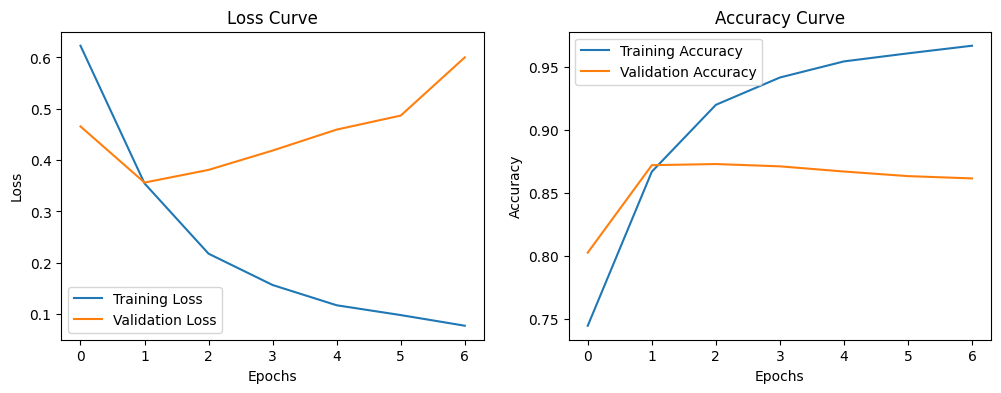

In [20]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
